# 🛠 Install Libraries

In [4]:
'''
ak_UWMGI[Train]

'''

# インストール済みなので、コメントアウト
#!pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
#!pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
#!pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
#!pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

'\nak_UWMGI[Train]\n\n'

# 📚 Import Libraries 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from PIL import Image
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
# tifffile.imread("ファイル名")でtiff画像を読み込める
import tifffile as tiff 

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

#import timm 今のところ不要

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Unetを使うためのライブラリをインポート(smp)
import segmentation_models_pytorch as smp

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⚙️ Configuration 

In [5]:
class CFG:
    coef_thr = 0.5
    thr = 0.5
    mean = np.array([0.7720342,0.74582646,0.76392896])
    std =  np.array([0.24745085,0.26182273,0.25782376])
    work_dir      = "/home/user/Desktop/hirao/ftu_segmentation/"
    # 分割用画像入力フォルダ
    input_dir_1   = os.path.join(work_dir,"train")
    # 分割用マスク入力フォルダ
    input_dir_2   = os.path.join(work_dir,"mask")
    # 出力ファイルの接尾辞
    out_dir_suf   = "_c"
    # 切り取りサイズx,y(imagenetと同じ256x256のパッチに切り分ける)
    x_csize       = 256
    y_csize       = 256
    
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = '2.5D'
    comment       = 'unet-efficientnet_b0-160x192-ep=5'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b0'
    # このコンペはデータが315しかないのでbsも小さく設定する
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = [3072, 3072] # 最大の画像に合わせる, ここで使うunetは最低解像度が32x32の関係で、画像サイズが32の倍数でないとエラーになる構造なので要注意！
    img_size_t    = [3072, 3072]
#    epochs        = 20
    epochs        = 5
    lr            = 2e-3
#    lr            = 1e-2
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
#    T_max         = int(500/train_bs*epochs)+50
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    # 基本的にbsは1程度なので、ロスが小さくなりすぎる要因を消しておく
#    n_accumulate  = 1
    n_fold        = 5
    folds         = [0, 1, 2, 3, 4] # CVの回数(5なら,5つに分けたfoldにおいて検証データが全パターン出る)
    num_classes   = 1
#    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # 背景と見做す白色の割合(0.8以上は背景)
    w_th          = 0.8
    
    # 背景除外を使用するかどうか(True or False)
    use_white_area = True
    

In [6]:
'''
train.csvを読み込みdfを作成
'''
df = pd.read_csv(
    os.path.join(CFG.work_dir,"train.csv"))
#image_ids = df.id
#image_files = glob(CFG.work_dir+"train_images/*")
df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [7]:
'''
画像のID列とパス列を持つpath_dfを作成
あとでdfに結合
'''
path_df = pd.DataFrame(glob(CFG.work_dir+'train_images/*'), columns=['image_path'])
# image_path列のファイル名だけ取り出し'.tiff'を除くことでid列を作成(例：62,203,1500)
path_df['id'] = path_df.image_path.map(lambda x: int(x.split('/')[-1].replace('.tiff','')))
#print(path_df['id'])
path_df.head()

,image_path,id
0,/home/user/Desktop/hirao/ftu_segmentation/trai...,15732
1,/home/user/Desktop/hirao/ftu_segmentation/trai...,10044
2,/home/user/Desktop/hirao/ftu_segmentation/trai...,15787
3,/home/user/Desktop/hirao/ftu_segmentation/trai...,10274
4,/home/user/Desktop/hirao/ftu_segmentation/trai...,15842


In [8]:
'''
dfにpath_dfを結合 (dfにimage_pathが追加)
'''
df = df.merge(path_df, on=['id'])
df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,image_path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,/home/user/Desktop/hirao/ftu_segmentation/trai...


In [9]:
# mask作成関数
# ランレングス符号➡マスクの変換を行う関数
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [10]:
'''

マスク画像を作成し、全画像とマスク画像をnpy形式で保存する関数

全画像を読み込み(img)、マスクを作成(mask)する。(imgはresizeしている)
1枚ずつ読み込む関数なので、for文の中で実行する。

'''
# id    = image_idsからfor文内部で読み込む
# image = image_files(画像パス)からfor文内部で読み込む
def load_img_mask(id,img_path):
#    print("id:",id)
#    print("img_path:",img_path)
    # tiff画像を読み込む
    img = tiff.imread(img_path)
    # 原点のピクセル値確認
#    print("img:\n",img[0,0])
    # 画像の形状を読み込む
    shape0 = np.array(img.shape[:2])                # img形状を読み込みnp配列にする
    resize = np.array(CFG.img_size)             # array([3000,all])...指定した変更後サイズをnp配列にする
    
    # 画像のサイズ変更において、大きくなる際に歪まない方法
    # このコンペでは3070→3000と画像が小さくなるパターンもあるが、大丈夫？    
    if np.any(shape0!=resize):                      # 「元サイズ」と「変更後サイズ」が異なる場合に以下の処理をする
        diff = resize - shape0                      # 「元サイズ」「変更後サイズ」の差分
        pad0 = diff[0]                              # diff[0]=差分の縦サイズ
        pad1 = diff[1]                              # diff[1]=差分の横サイズ
        pady = [pad0//2, pad0//2 + pad0%2]          # pady=[差分縦の半分, 差分縦の半分 + 縦の差分を2で割った余り(0 or 1)]
        padx = [pad1//2, pad1//2 + pad1%2]          # padx=padyの横ver
        # 画像をrgbに分けて、それぞれ原点のピクセル値で埋め合わせてから、元のRGB画像に戻している。
#        image = []        
#        for idx in range(img.shape[2]):
#            img_0 = np.pad(img[:,:,idx], [pady, padx], constant_values=(img[:,:,idx][0,0]))
#            image.append(img_0)
#        img = np.asarray(image)

        # 画像をrgbに分けて、それぞれ原点のピクセル値で埋め合わせてから、元のRGB画像に戻している。img.shape[2]=チャンネル数(RGB)
        # こちらを使う場合、1行下のnp.pad...をコメントアウト        
        img = np.asarray([np.pad(img[:,:,idx], [pady, padx], constant_values=(img[:,:,idx][0,0])) for idx in range(img.shape[2])])

        # 画像の周囲を0で埋めている。
        # こちらを使う場合、上記のnp.asarray...をコメントアウト
#        img = np.pad(img, [pady, padx])

        img = img.transpose(1,2,0)
        img = img.reshape((*resize, 3))             # 変更前後のサイズにreshape(形状変更):1行前の時点で既にこの形状になっている場合が多いか

    # reshapeした画像をnpy形式で保存
    np.save(f'{CFG.work_dir}train/{id}.npy',img)
    
    
    # idに一致するrle(ランレングス符号)を読み込み、リサイズ前のimgのサイズに合わせてマスクに変換する
    mask = rle2mask(df[df["id"]==id]["rle"].iloc[-1], (shape0[1], shape0[0]))
    
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        mask = np.pad(mask, [pady, padx]) # マスクは2次元
        mask = mask.reshape((resize))    # マスクは2次元

    # reshapeしたマスクをnpy形式で保存
    np.save(f'{CFG.work_dir}mask/{id}.npy',mask)
    
    return img, mask


(3072, 3072, 3)
(3072, 3072)
[241 241 236]
1


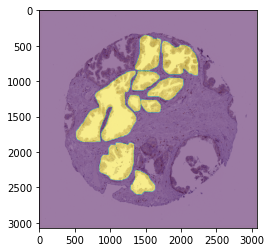

In [11]:
'''
画像表示テスト用
'''
row = 0

img, mask = load_img_mask(df.loc[row,"id"],df.loc[row,"image_path"])

print(img.shape)
print(mask.shape)
print(img[0,0])
print(mask[2200,1000])
plt.imshow(img)
plt.imshow(mask,alpha=0.5)
#plt.axis("off")
plt.show()

In [14]:
'''

元画像とマスク画像を.npyファイルとして保存する

'''
# 画像のnpyファイルを保存するフォルダを作成
os.makedirs(os.path.join(CFG.work_dir,"train"),exist_ok=True)
os.makedirs(os.path.join(CFG.work_dir,"mask"),exist_ok=True)

# idと画像ファイルの数だけ繰り返し
for (id,img_path) in tqdm(zip(df["id"],df["image_path"]),total=len(df["id"])):
    load_img_mask(id,img_path)

100%|█████████████████████████████████████████████████████████████████████████████████| 351/351 [02:58<00:00,  1.97it/s]


img: /home/user/Desktop/hirao/ftu_segmentation/train/10392.npy
msk: /home/user/Desktop/hirao/ftu_segmentation/mask/10392.npy


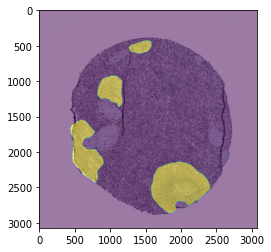

msk1_pixel: [0]


In [12]:
'''
リサイズ後の画像とマスク確認用コード
'''

def load_img_mask21(img_path,msk_path):
    ## 画像読み込み部分
    # numpy画像を読み込む
    print("img:",img_path)
    print("msk:",msk_path)
    img = np.load(img_path)
    img = img.astype('float32') # original is uint8か
    # 最大画素値で割り、[0-1]のnumpy配列imgに変換して返す
#    img /= 255.0
    img = (img/255.0 - CFG.mean)/CFG.std
    
    ## マスク読み込み部分
    # numpyマスク画像を読み込む
    msk = np.load(msk_path)
    # チャンネルの次元を追加
    msk = msk.reshape(CFG.img_size[0],CFG.img_size[1],1)
    msk = msk.astype('float32') # original is uint8か
    # マスクは元から0～1なので255で割る必要がない。
    # 最大画素値で割り、[0-1]のnumpy配列imgに変換して返す
#    msk /= 255.0
    
    return img, msk

img1, msk1 = load_img_mask21("/home/user/Desktop/hirao/ftu_segmentation/train/10392.npy","/home/user/Desktop/hirao/ftu_segmentation/mask/10392.npy")

# 正規化のみの場合
#img1 = img1 * 255
# 標準化の場合
img1 = (img1 * CFG.std + CFG.mean)* 255
img1 = img1.astype('uint8')

msk1 = msk1 * 255
msk1 = msk1.astype('uint8')

plt.imshow(img1)
plt.imshow(msk1,alpha=0.5)
plt.show()
print("msk1_pixel:",msk1[2200,1000])

In [13]:
'''

画像のID列とパス列を持つpath_df2を作成
あとでdfに結合

'''
# DF内の要素で表示する文字数
#pd.set_option("display.max_colwidth", 80)

path_df2 = pd.DataFrame(glob(CFG.work_dir+'train/*'), columns=['image_path'])
# image_path列のファイル名だけ取り出し'.tiff'を除くことでid列を作成(例：62,203,1500)
path_df2['id'] = path_df2.image_path.map(lambda x: int(x.split('/')[-1].replace('.npy','')))
path_df2['mask_path'] = path_df2.image_path.str.replace('train','mask')
#print(path_df['id'])
#print(path_df2["image_path"])
#print(path_df2["mask_path"])
path_df2.head()

,image_path,id,mask_path
0,/home/user/Desktop/hirao/ftu_segmentation/trai...,15860,/home/user/Desktop/hirao/ftu_segmentation/mask...
1,/home/user/Desktop/hirao/ftu_segmentation/trai...,9769,/home/user/Desktop/hirao/ftu_segmentation/mask...
2,/home/user/Desktop/hirao/ftu_segmentation/trai...,10912,/home/user/Desktop/hirao/ftu_segmentation/mask...
3,/home/user/Desktop/hirao/ftu_segmentation/trai...,12452,/home/user/Desktop/hirao/ftu_segmentation/mask...
4,/home/user/Desktop/hirao/ftu_segmentation/trai...,6120,/home/user/Desktop/hirao/ftu_segmentation/mask...


In [14]:
'''

dfにpath_df2を結合 
(dfから.tiffのimage_pathを削除し、
.npyの新たなimage_pathとmask_pathが追加)

'''
df = df.drop("image_path",axis=1)
df = df.merge(path_df2, on=['id'])
df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,image_path,mask_path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...,/home/user/Desktop/hirao/ftu_segmentation/mask...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...,/home/user/Desktop/hirao/ftu_segmentation/mask...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...,/home/user/Desktop/hirao/ftu_segmentation/mask...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...,/home/user/Desktop/hirao/ftu_segmentation/mask...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,/home/user/Desktop/hirao/ftu_segmentation/trai...,/home/user/Desktop/hirao/ftu_segmentation/mask...


In [15]:
'''

画像分割用のコード
(入力画像とマスクをすべて256x256に切り分ける)
画像が

関数セル
'''
import os
import sys
import numpy as np
from PIL import Image

def load_img_mask3(img_path,msk_path):
    ## 画像読み込み部分
    # numpy画像を読み込む
    img = np.load(img_path)
    
    ## マスク読み込み部分
    # numpyマスク画像を読み込む
    msk = np.load(msk_path)
    
    return img, msk


#画像における背景（白い部分）割合カウント用関数(レベル0ベース)
def count_white_area (img_w):
    
    #グレースケールに変換
    img_grayimg = cv2.cvtColor(img_w, cv2.COLOR_BGR2GRAY)

    #ぼかし
    kernel = np.ones((10,10),np.float32)/100
    blur_img = cv2.filter2D(img_grayimg,-1,kernel)

    #二値化
    #画像サイズにより適宜調整を！！
    # 解像度レベル0は以下
#    bi_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 41, 7)
    # 少し低めの解像度は以下
    bi_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 21, 4)

    #近傍の定義
    neiborhood = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]],np.uint8)

    # 縮小、膨張
    # 解像度レベル0は以下
#    img_dilate = cv2.dilate(bi_img,neiborhood,iterations=3)
#    img_erode = cv2.erode(img_dilate,neiborhood,iterations=20)
    # 解像度レベル2は以下
    img_dilate = cv2.dilate(bi_img,neiborhood,iterations=1)
    img_erode = cv2.erode(img_dilate,neiborhood,iterations=15)
    
    #白（背景）のピクセル数を算出
    white = cv2.countNonZero(img_erode)
    white_area = white /(img_w.shape[0]*img_w.shape[1])
    
    return white_area


# 画像とマスク切り取り保存用の関数(切り取り幅は引数で設定)
def mk_patch(input_dir_1, input_dir_2, out_dir_suf, x_csize, y_csize):
    
    # 出力フォルダの用意
    # 画像入力フォルダ名に接尾辞を与える。
    out_dir_1 = input_dir_1 + out_dir_suf

    # 出力フォルダが無ければ作成
    os.makedirs(out_dir_1, exist_ok=True)

    # 画像入力フォルダ名に接尾辞を与える。
    out_dir_2 = input_dir_2 + out_dir_suf
    
    # 出力フォルダが無ければ作成
    os.makedirs(out_dir_2, exist_ok=True)
    
    # フォルダから画像ファイル、マスクファイルを読み込む
    for (id,img_path,msk_path) in tqdm(zip(df["id"],df["image_path"],df["mask_path"]),total=len(df["id"])):
        
        # 画像ファイル、マスクファイルを開く
        im, msk = load_img_mask3(img_path, msk_path)

        # 背景削除用にCV2形式に変換
        im_cv2 = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

        # 画像の横幅と縦の長さをそれぞれimg_x, img_yに代入する
        # おそらく0番目がyで1番目がxのはず
        img_x = im.shape[1]
        img_y = im.shape[0]
                
        # 画像サイズのyを切り取り、サイズで割った回数繰り返す。(例: 画像のy=32を8ずつ切りたい場合=> 32/8 = 4回)
        for i in range(int(img_y / y_csize)):
            # 画像サイズのxを切り取りサイズで割った回数繰り返す。(例: 画像のx=24を8ずつ切りたい場合=> 24/8 = 3回)
            for j in range(int(img_x / x_csize)):
                
                # 画像を切り取り
                # 指定サイズに切り取る(x_csize * j＝ x座標のスタート、y_csize * i = y座標のスタート)
                # im[y_start:y_end, x_start:x_end]
                # y＝＞xの順なので要注意
                im_c = im[y_csize * i : y_csize * i + y_csize, x_csize * j : x_csize * j + x_csize]

                # マスクを切り取り
                msk_c = msk[y_csize * i : y_csize * i + y_csize, x_csize * j : x_csize * j + x_csize]
                
                # 背景削除用のCV2形式画像の切り取り
                im_cv2_c = im_cv2[y_csize * i : y_csize * i + y_csize, x_csize * j : x_csize * j + x_csize]
                
                # 背景除外の関数を用いる場合は、count_white_area関数を呼び出す。
                if CFG.use_white_area:
                    white_area = count_white_area(img_w = im_cv2_c)
                else:
                    # 背景除外しないなら、0にしておく。
                    white_area = 0

                #白の割合がw_th以上のものは推論～合成の対象外とする。
                if white_area < CFG.w_th:
                    # 画像を出力フォルダに保管する。
                    np.save(f'{out_dir_1}/{id}_{j}_{i}.npy',im_c)
                    
                    # マスクを出力フォルダに保管する。
                    np.save(f'{out_dir_2}/{id}_{j}_{i}.npy',msk_c)                
                                                    

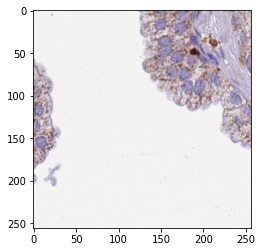

In [16]:
## train_cを作る前で、まだない場合、以下コードはエラーになってしまうので、その場合はコメントアウトしておく
img2, msk2 = load_img_mask3("/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_5_5.npy","/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_5_5.npy")
img2, msk2 = load_img_mask3("/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_4_5.npy","/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_4_5.npy")
plt.imshow(img2)
plt.show()

In [17]:
#画像における背景（白い部分）割合カウント用関数(レベル0ベース)
def count_white_area_s (img_w):
    
    #グレースケールに変換
    img_grayimg = cv2.cvtColor(img_w, cv2.COLOR_BGR2GRAY)

    #ぼかし
    kernel = np.ones((10,10),np.float32)/100
    blur_img = cv2.filter2D(img_grayimg,-1,kernel)

    #二値化
    #画像サイズにより適宜調整を！！
    # 解像度レベル0は以下
    bi_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 41, 7)
    

    #近傍の定義
    neiborhood = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]],np.uint8)

    # 縮小、膨張
    # 解像度レベル0は以下
    img_dilate = cv2.dilate(bi_img,neiborhood,iterations=3)
    img_erode = cv2.erode(img_dilate,neiborhood,iterations=20)
    
    #白（背景）のピクセル数を算出
    white = cv2.countNonZero(img_erode)
    white_area = white /(img_w.shape[0]*img_w.shape[1])

    plt.imshow(img_erode)
    plt.show()
    
    return white_area


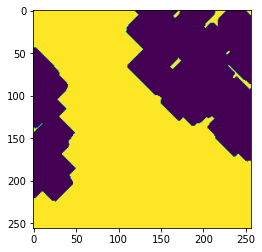

0.633758544921875


In [18]:
## 二値化の確認用 上の方のimg2を作成しているコードがコメントアウトされている場合は、こちらもコメントアウトする
img2_2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
img2_2 = img2_2.astype("uint8")
ss = count_white_area_s (img2_2)
print(ss)

In [127]:
'''

スペシャルコード
(入力画像とマスクをすべて256x256に切り分ける)

実行セル
'''
mk_patch(CFG.input_dir_1, CFG.input_dir_2, CFG.out_dir_suf, CFG.x_csize, CFG.y_csize)


100%|█████████████████████████████████████████████████████████████████████████████████| 351/351 [03:29<00:00,  1.68it/s]


In [19]:
# ① df1=
# 1.行ごとにコピーする数を書いた列を作成する、すべて同じ数をコピーするので容易かも (12 x 12 = 144)
# 2.
df["copy"] = int(CFG.img_size[0]/CFG.x_csize)
df = df.iloc[np.repeat(np.arange(len(df)), df['copy'].to_numpy())]
df = df.reset_index(drop=True)
df = df.reset_index()
df["index2"] = df["index"]%(int(CFG.img_size[0]/CFG.x_csize))
df = df.iloc[np.repeat(np.arange(len(df)), df['copy'].to_numpy())]
df = df.drop(columns="index")
df = df.reset_index(drop=True)
df = df.reset_index()
df["index3"] = df["index"]%(int(CFG.img_size[1]/CFG.y_csize))
df["id2"] = df["id"].astype(str)+"_"+df["index3"].astype(str)+"_"+df["index2"].astype(str)
# "id"列＝＞"id_o"列にrenameして残す
df = df.rename(columns={"id":"id_o"})
df = df.drop(columns=["index2","index3","index"])
df = df.rename(columns={"id2":"id"})
df = df.drop(columns=["image_path","mask_path"])

df.head()

,id_o,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,copy,id
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,12,10044_0_0
1,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,12,10044_1_0
2,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,12,10044_2_0
3,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,12,10044_3_0
4,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,12,10044_4_0


In [20]:
# ② df2=path_df3作成
pd.set_option("display.max_colwidth", 80)

path_df3 = pd.DataFrame(glob(CFG.work_dir+'train_c/*'), columns=['image_path'])
# image_path列のファイル名だけ取り出し'.tiff'を除くことでid列を作成(例：62,203,1500)
path_df3['id'] = path_df3.image_path.map(lambda x: x.split('/')[-1].replace('.npy',''))
path_df3['mask_path'] = path_df3.image_path.str.replace('train','mask')

#print(path_df['id'])
#print(path_df2["image_path"])
#print(path_df2["mask_path"])
path_df3

,image_path,id,mask_path
0,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_4_1.npy,10044_4_1,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_4_1.npy
1,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_5_1.npy,10044_5_1,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_5_1.npy
2,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_6_1.npy,10044_6_1,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_6_1.npy
3,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_7_1.npy,10044_7_1,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_7_1.npy
4,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_3_2.npy,10044_3_2,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_3_2.npy
...,...,...,...
29405,/home/user/Desktop/hirao/ftu_segmentation/train_c/9470_9_6.npy,9470_9_6,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9470_9_6.npy
29406,/home/user/Desktop/hirao/ftu_segmentation/train_c/9470_10_6.npy,9470_10_6,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9470_10_6.npy
29407,/home/user/Desktop/hirao/ftu_segmentation/train_c/9470_1_7.npy,9470_1_7,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9470_1_7.npy
29408,/home/user/Desktop/hirao/ftu_segmentation/train_c/9470_2_7.npy,9470_2_7,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9470_2_7.npy


In [21]:
df = df.merge(path_df3, on=['id'], how="inner")
df

,id_o,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,copy,id,image_path,mask_path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 1...,37.0,Male,12,10044_4_1,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_4_1.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_4_1.npy
1,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 1...,37.0,Male,12,10044_5_1,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_5_1.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_5_1.npy
2,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 1...,37.0,Male,12,10044_6_1,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_6_1.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_6_1.npy
3,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 1...,37.0,Male,12,10044_7_1,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_7_1.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_7_1.npy
4,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 1...,37.0,Male,12,10044_3_2,/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_3_2.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_3_2.npy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29405,9904,largeintestine,HPA,3000,3000,0.4,4,1009165 7 1012149 28 1015140 38 1018127 51 1021112 62 1021176 4 1024109 73 1...,84.0,Male,12,9904_6_10,/home/user/Desktop/hirao/ftu_segmentation/train_c/9904_6_10.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9904_6_10.npy
29406,9904,largeintestine,HPA,3000,3000,0.4,4,1009165 7 1012149 28 1015140 38 1018127 51 1021112 62 1021176 4 1024109 73 1...,84.0,Male,12,9904_7_10,/home/user/Desktop/hirao/ftu_segmentation/train_c/9904_7_10.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9904_7_10.npy
29407,9904,largeintestine,HPA,3000,3000,0.4,4,1009165 7 1012149 28 1015140 38 1018127 51 1021112 62 1021176 4 1024109 73 1...,84.0,Male,12,9904_8_10,/home/user/Desktop/hirao/ftu_segmentation/train_c/9904_8_10.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9904_8_10.npy
29408,9904,largeintestine,HPA,3000,3000,0.4,4,1009165 7 1012149 28 1015140 38 1018127 51 1021112 62 1021176 4 1024109 73 1...,84.0,Male,12,9904_5_11,/home/user/Desktop/hirao/ftu_segmentation/train_c/9904_5_11.npy,/home/user/Desktop/hirao/ftu_segmentation/mask_c/9904_5_11.npy


# ❗ Reproducibility

In [22]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Meta Data

* Files
    * train.csv - IDs and masks for all training objects.
    * sample_submission.csv - a sample submission file in the correct format
    * train - a folder of case/day folders, each containing slice images for a particular case on a given day.

> Note that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * id - unique identifier for object
    * class - the predicted class for the object
    * EncodedPixels - RLE-encoded pixels for the identified object

# 🔨 Utility

## Mask

## Image

In [23]:
import cv2

# 画像表示用の関数(画像を引数に取る)
def show_img(img, mask=None): # createCLAHE：画素値の偏りを分配して平坦化する。
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# imgに適用して表示する。画像が持つ同じ画素値の最大数(clipLimit)を制限、広い範囲の画素を持つようにヒストグラムを平坦化することでコントラストを改善する。コントラスト強調の一種でもある。
# しかし、ここではコメントアウトされており、コントラスト強調は使われていない
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    # シンプルに画像をグレースケール調のカラーマップで表示する。
    plt.imshow(img, cmap='bone')
    # maskがある場合は、凡例と共に表示する
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        # 半透明のマスクを表示
        plt.imshow(mask, alpha=0.5)
        # 一時チェック用、なぜかマスクの色がおかしい
#        plt.imshow(mask)
        # マスクの凡例として、FTUを赤で四角と、文字で表示
        handles = [Rectangle((0,0),1,1, color=(1.0,1.0,0.0))]
        labels = ["FTU"]
        plt.legend(handles,labels)
    plt.axis('off')

## RLE

# 📁 Create Folds

In [24]:
'''

KFoldを実施して、fold番号を記載した列をdfに追加する。
臓器ごとにfoldがバラバラになるので、必ずFoldの数だけ学習が必要だと思われる。

'''

# CVのフォールドを、グループKフォールドで作成
# インスタンス
skf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
#skf = GroupKFold(n_splits=CFG.n_fold)
# organが同じものは同じフォールドに含まれるようにgroupとして指定する。　              ＝＞ グループ
#for fold, (train_idx, val_idx) in enumerate(skf.split(df, groups = df["organ"])):
'''
学習時のリークを防ぐため、同じ画像のものは同じfoldに入れるように工夫
① 画像分割前のidでKFoldを実施
② 各Foldの検証用のidは得られるので、各foldでid_o列(旧ID)が
'''
# 元の学習用csvのid列を読み込み
ids = pd.read_csv(os.path.join(CFG.work_dir,"train.csv")).id.astype(str).values
# 元idをfoldに分けてから、分割後のidに振り分ける。(元画像が同じ分割画像は、同じfoldになるように調節)
for fold, (train_idx,val_idx) in enumerate(skf.split(ids)):
    df["fold_check"] = df.loc[:,'id_o'].astype(str).isin(list(ids[val_idx]))
    df.loc[df["fold_check"]==True,'fold'] = fold
df = df.drop(columns="fold_check")   
'''
元画像を無視してfoldを振り分けた場合は以下
'''
#for fold, (train_idx, val_idx) in enumerate(skf.split(df)):
#    # ["fold"]列の追加
#    # 行：val_idx,列：foldの要素にfold番号(0~4)を入れる
#    # 検証データ対象となった行のフォールド番号を入れる。
#    # つまり、0~4のどのフォールドで検証データになるのか、fold列を見れば分かる。
#    df.loc[val_idx, 'fold'] = fold
## 各フォールドの,segment列が空の要素数と空でない要素数を表示
display(df.groupby(['fold','sex'])['id'].count())

fold  sex   
0.0   Female    2314
      Male      3657
1.0   Female    2565
      Male      3308
2.0   Female    1663
      Male      4225
3.0   Female    1768
      Male      4102
4.0   Female    1636
      Male      4172
Name: id, dtype: int64

In [25]:
'''

.npy形式で保存した画像とマスクを読み込む関数

'''

def load_img_mask2(img_path,msk_path):
    ## 画像読み込み部分
    # numpy画像を読み込む
    img = np.load(img_path)
    img = img.astype('float32') # original is uint8か
    # 最大画素値で割り、[0-1]のnumpy配列imgに変換して返す
#    # 正規化の場合
#    img /= 255.0
    # 標準化の場合
    img = (img/255.0 - CFG.mean)/CFG.std
    
    ## マスク読み込み部分
    # numpyマスク画像を読み込む
    msk = np.load(msk_path)
    # チャンネルの次元を追加
    msk = msk.reshape(CFG.x_csize,CFG.y_csize,1)
    msk = msk.astype('float32') # original is uint8か
    # 最大画素値で割り、[0-1]のnumpy配列imgに変換して返す
    # mskは最初から[0-1]なので、255で割る意味がない
#    msk /= 255.0
    
    return img, msk

# 🍚 Dataset

In [26]:
'''
Dataset作成
'''
# データセットを作成するクラス
# 推論コードとの違い＝id列(df['id'])が使われていない
# データローダーから呼び出されており、既にtrainデータとvalidデータが分かれた状態
# train,validそれぞれについて呼び出される。
class BuildDataset(torch.utils.data.Dataset):
    # dfを入れる。
    # BuildDatasetの呼び出し元を確認したところ、
    def __init__(self, df, transforms=None):
        self.df         = df
        # Df img_paths列をリストに変換しself.img_pathsに入れる
        self.img_paths = df['image_path'].tolist()
        self.msk_paths = df['mask_path'].tolist()
        # self.transformsにtransformsを入れる。基本的にdata_transformsから"valid"か"train"か選んだ場合の前処理が入る。
        self.transforms = transforms
        
    # dfの長さを返す        
    def __len__(self):
        return len(self.df)
    
    # インデックスを指定して画像を取り出す
    def __getitem__(self, index):
#        print("index番号:",index)
        # 指定したインデックスの画像パスを取り出す
        img_path  = self.img_paths[index]
        msk_path  = self.msk_paths[index]
        img = []
        # img_pathから画像(.npy)を読み込みimgに入れる。msk_pathからマスク(.npy)を読み込みmskに入れる。
        img, msk = load_img_mask2(img_path, msk_path)
#        print("img_shape:",img.shape)
#        print("msk_shape:",msk.shape)
                
        # 前処理が指定されている場合は、前処理後のデータセットをdataに入れる
        if self.transforms:
            data = self.transforms(image=img, mask=msk)
            # dataの画像imageをimgに入れる
            img  = data['image']
            # dataのマスクmaskをmskに入れる
            msk  = data['mask']
        # imgとmskをopenCV形式(高さ, 幅, チャンネル)からtensor形式(チャンネル, 高さ, 幅)に並べ替える
        img = np.transpose(img, (2, 0, 1))
        msk = np.transpose(msk, (2, 0, 1))
        # imgとmskをtensorに変換して返す
        return torch.tensor(img), torch.tensor(msk)

# 🌈 Augmentations

In [27]:
'''
データ拡張
'''
# API albumentaitonでデータ拡張(参考：https://qiita.com/kurilab/items/b69e1be8d0224ae139ad)
data_transforms = {
    # 学習(train)を指定した場合、データ拡張のAlbumentationsライブラリで以下の処理を実施(画像もマスクも同じように拡張してくれる)
    # ①水平フリップ(50%)、②ランダムアフィン変換[水平移動:max=0.0625,拡大縮小:max=0.05,回転:max=10](50%)、
    # ③("グリッド歪み"か"弾性変形")のどちらか片方をランダム(25%)、④画像に黒四角のノイズ入れる（=指定矩形範囲(高さ:max=画像の1/20,幅:max=画像の1/20)でmin=5箇所、max=8箇所、0(黒)にする）変換(50%)    
    "train": A.Compose([
#         A.Resize(*CFG.x_csize, interpolation=cv2.INTER_NEAREST),
#         A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
#             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.x_csize//20, max_width=CFG.y_csize//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    # 検証(valid)を指定した場合、特に何も行わない(コメント削除でリサイズ)
    "valid": A.Compose([
#         A.Resize(*CFG.x_csize, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# 🍰 DataLoader

In [28]:
'''
データローダー
'''
# この関数では、Foldでtrainとvalidにデータを分けた後、PytorchのDataLoaderを用いている。

# フォールドを引数としてローダーを準備 (今の設定では、CFG.folds=[0]のため、常にfold=0となっている)
# この時点では、fold=0の1回だけKFoldを行う形？
def prepare_loaders(fold, debug=False):
    # fold列の値がfold(@fold)以外の行を取り出してtrain_dfに入れる
    # インデックスはリセットして旧インデックス列は削除する
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    # fold列の値がfold(@fold)の行を取り出してvalid_dfに入れる
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    print("train_df:",len(train_df))
    print("valid_df:",len(valid_df))
    # debugは学習ではFalseにしている
    # debugがTrueなら、train_dfの頭32行、valid_dfの頭8行取り出す
    if debug:
        train_df = train_df.head(8*4)
        valid_df = valid_df.head(8*1)
    # train,validそれぞれに合わせた前処理を行いデータセットを作成する。
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    # DataLoaderを用いて、バッチサイズ等(デバッグの場合は20)を指定して、バッチ数毎のデータローダーを作成する
    # num_workers:マルチ処理数=大体2で良いらしい、デフォルトはシングル処理なので遅い
    # shuffle=True(シャッフル)、pin_memory=True=>メモリ領域がページングされなくなり、高速化が期待できる。
    # drop_last=>バッチ数で割り切れないデータをどうするか？True:除去,False:そのまま使う
    # 学習時：True＝＞バッチ内のデータ数を揃えるのが望ましいケースがある、今回はFalseになっているが
    #              (1枚だけでバッチを形成すると、その1枚の影響力が他画像より大きくなる恐れがあるため)
    # 検証時：False＝＞検証という観点では、使用しないデータがある状況は避けた方が良い。(できるだけ全部のデータを活用)
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 5, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 5, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    # バッチ数毎のデータを返す
    return train_loader, valid_loader


In [29]:
# prepare_loadersを利用して、学習用データローダーと検証用データローダーを取得
# それぞれ、層化グループK-Foldで学習用：検証用＝4:1に分割されている。
# ただし、通常のCVのように検証データを変えながら5回実施するのではなく、1回だけ実施される。
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

train_df: 23439
valid_df: 5971


In [30]:
# 学習用データローダーから、指定バッチサイズの画像とマスクのセットを取り出す
imgs, msks = next(iter(train_loader))
# [検証]画像サイズとマスクサイズを表示
print("train_loader:\n",imgs.size(), msks.size())
# 検証用データローダーから、指定バッチサイズの画像とマスクのセットを取り出す
#imgs2, msks2 = next(iter(valid_loader))
# [検証]画像サイズとマスクサイズを表示
#print("valid_loader:\n",imgs2.size(), msks2.size())

train_loader:
 torch.Size([5, 3, 256, 256]) torch.Size([5, 1, 256, 256])


# 📈 Visualization

In [31]:
'''
画像は0～１に正規化した。
'''

def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    # 3回繰り返し
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        # 表示用にpermuteで次元を入れ替えて0~1の値を1~255になるよう255倍して表示
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        # 表示用にpermuteで次元を入れ替えて0~1の値を1~255になるよう255倍して表示
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        #チェック用
        print("msk:\n",np.shape(msk))
        # show_img関数でimgとmskのセットでの表示設定について調整し表示
        show_img(img, msk)
    # tight_layout => subplotを用いる場合に、画像の間隔をある程度自動調整してくれる
    # 但しver3.2.1ではsuptitleと被る可能性があるので、その場合は手動のサイズ調整が必要
    plt.tight_layout()
    plt.show()

msk:
 (256, 256, 1)


NameError: name 'Rectangle' is not defined

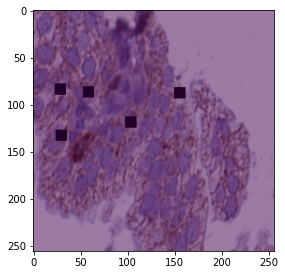

In [141]:
# 1batchの画像＆重なるマスクを指定サイズ数(5枚)表示
plot_batch(imgs, msks, size=5)

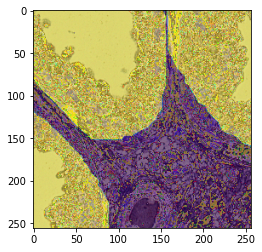

In [32]:
img1, msk1 = load_img_mask2("/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_5_5.npy","/home/user/Desktop/hirao/ftu_segmentation/mask_c/10044_5_5.npy")

img1 = img1 * 255
img1 = img1.astype('uint8')

msk1 = msk1 * 255
msk1 = msk1.astype('uint8')

plt.imshow(img1)
plt.imshow(msk1,alpha=0.5)
plt.show()


In [33]:
import gc
gc.collect()

16848

# 📦 Model

In [34]:
# モデルの指定と、encoderの形状(efficient_net)、事前学習用の重みの設定(imagenet)、入力チャンネル数、分類クラス数(3:大腸,小腸,胃)
# 活性化関数はなしになっている。
def build_model():
#    model = smp.UnetPlusPlus(
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    # モデルをGPUかCPUに送る
    model.to(CFG.device)
    # モデルを返す
    return model

# モデル読み込み関数、恐らく学習後の検証・テスト時にのみ使われる
def load_model(path):
    # build_modelでモデル構築
    model = build_model()
    # 指定したpathからモデルのパラメータを読み込んでいる
    model.load_state_dict(torch.load(path))
    # 検証モード(逆伝播用のデータを記録しないモード)
    model.eval()
    # モデルを返す
    return model

# 🔧 Loss Function

In [35]:
# ロス関数の設定

# 若干の漏れやはみだしを検知したい＝＞JaccardLoss(混同行列、F値に似た指標)
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
# 1-F値で算出するロス,今回のコンペの判断基準なので重要
DiceLoss    = smp.losses.DiceLoss(mode='binary')
# 2値交差エントロピー誤差
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
# 離散値になるJaccardをより連続的に表せるようにしたもの
LovaszLoss  = smp.losses.LovaszLoss(mode='binary', per_image=False)
# F値における、分母の偽陽性と偽陰性に重みづけをしたもの(重み=1/2でF値になる)
# 重み(alpha,beta)==0.5がデフォルト設定なので、
# ここではDiceLoss(1-F値)と同一
TverskyLoss = smp.losses.TverskyLoss(mode='binary', log_loss=False)

# Dice係数(F値)
def dice_coef(y_true, y_pred, thr = CFG.coef_thr, dim=(2,3), epsilon=0.001):
    # 正解データ(float32変換)
    y_true = y_true.to(torch.float32)
    # thr(0.5)を超える値の予測値をマスクのある箇所としてy_predとする(float32変換)
    y_pred = (y_pred>thr).to(torch.float32)
    # inter＝正解と予測値の積和
    inter = (y_true*y_pred).sum(dim=dim)
    # den=正解の総和 + 予測値の総和
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    # 2*(積和)/(総和)　epsilonはden等が0の時のエラーを避けるための小さい値
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

# Jaccard係数
def iou_coef(y_true, y_pred, thr=CFG.coef_thr, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

# 実際に使われている損失関数
def criterion(y_pred, y_true):
    # diceloss(1-F値)
    return DiceLoss(y_pred, y_true)

# 🚄 Training Function

In [36]:
# 1エポック学習する際の関数
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    # モデルを学習モードに切り替え
    model.train()
    # GradScalerを用いることで、学習速度を向上させ、GPU消費量を削減できる。
    # forward計算、loss計算、backward計算、パラメータ更新をラッピングする
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    # tqdmでバッチ数のプログレスバー作成(1バッチ進むごとにメーターが進む形式)
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    
    # pbarで1バッチごとの処理を実行する＝＞プログレスバーが表示される
    for step, (images, masks) in pbar:
        # データローダーから取り出した画像
        images = images.to(device, dtype=torch.float)
        # データローダーから取り出したマスク
        masks  = masks.to(device, dtype=torch.float)
        # チェック用
#        print("masks.size():\n",masks.size())
        # バッチサイズ＝画像の0次元目(バッチサイズ,チャンネル数,高さ,幅)
        batch_size = images.size(0)
        
        # amp.GradScalerを用いて計算を効率化するためにforward,backward,loss計算にamp.autocastを介在させている
        with amp.autocast(enabled=True):
            # モデルに画像を入力して予測値を求める
            y_pred = model(images)
            # y_predのサイズを確認(リストに複数の画像の予測値が出力？)
#            print("y_pred_size:\n",np.shape(y_pred))
            # 二値交差検証＋(1-F値)で損失計算
            loss   = criterion(y_pred, masks)
            # バッチ数が32より小さいときに、損失が小さくなるように調整している(n_accumulate=(1 or 32/バッチ数)の大きい方)
            loss   = loss / CFG.n_accumulate
        # 逆伝播
        scaler.scale(loss).backward()
    
        # step+1をn_accumulateで割った余りが0のとき(バッチ数が32より大きい場合は常にTrueのはず)
        if (step + 1) % CFG.n_accumulate == 0:
            # パラメータ更新を実施
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            # 次のバッチ計算用に勾配をゼロに戻す
            optimizer.zero_grad()
            
            # schedulerが設定されていたら、スケジューラに合わせて学習率の更新を実行?
            if scheduler is not None:
                scheduler.step()
        # 実行ロス = ロス x バッチサイズを加えていく => １エポック全体のロスが計算されると思われる
        running_loss += (loss.item() * batch_size)
        # データセットサイズにバッチサイズ(1バッチの画像枚数)を加えていく＝＞最終的に全画像数になる。
        dataset_size += batch_size
        
        # 1エポックの平均ロス値 = 全体ロス / 画像枚数
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        # 現行の学習率
        current_lr = optimizer.param_groups[0]['lr']
        # プログレスバーの右に、エポックロス、学習率、メモリーを表示する
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        # GPUメモリ解放
        torch.cuda.empty_cache()
        gc.collect()
    # 1エポックの平均ロスを返す
    return epoch_loss

# 👀 Validation Function

In [37]:
# 1エポック分検証する
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        # ダイス係数を計算
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        # Jaccard係数を計算
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        # ダイス係数とJaccard係数をそれぞれスコアとしてリストに保管
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [38]:
# 学習を実行する関数
# Dice係数を元に、ベストな値が更新されるたびにモデルをファイルに保存している
# 最終エポックのモデルも保存している
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
#    wandb.watch(model, log_freq=100)

    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    # エポック数だけ繰り返す
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        # 1エポック学習する関数を実行
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        # 1エポック検証する関数を実行
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        # 検証スコアのリストから、dice係数を変数に入れる
        val_dice,val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
#        wandb.log({"Train Loss": train_loss, 
#                   "Valid Loss": val_loss,
#                   "Valid Dice": val_dice,
#                   "Valid Jaccard": val_jaccard,
#                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        # dice係数がそれまでのベスト値よりも良かった場合、値が更新されたことを表示
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            # ベストダイス値に、この時のdice係数を代入
            best_dice    = val_dice
            # ベストjaccard値に、この時のjaccard係数を代入
            best_jaccard = val_jaccard
            # ベストepochに、この時のepochを代入
            best_epoch   = epoch
#            run.summary["Best Dice"]    = best_dice
#            run.summary["Best Jaccard"] = best_jaccard
#            run.summary["Best Epoch"]   = best_epoch
            # この時のモデルをbest_model_wtsに入れる(deepcopyなのでmodel.state_dict()が変わっても影響を受けない)
            best_model_wts = copy.deepcopy(model.state_dict())
            '''
            ベストエポックを上書きしてくれると思われる
            '''
            PATH = f"/home/user/Desktop/hirao/ftu_segmentation/best_epoch-{fold:02d}.bin"
            # モデルパラメータをPATH(best_epoch-OO.bin)として保存
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        # 最終エポックのモデルファイルも保存
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    # ベストのjaccard係数を表示
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    # 最終的なベストモデルを読み込む
    model.load_state_dict(best_model_wts)
    
    # ベストモデル、ロスやスコアの履歴リストを返す
    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [39]:
# パラメータに記載のschedulerに合わせてスケジューラを設定
# 最小学習率、半周期のステップサイズ、最適化アルゴリズムを指定
def fetch_scheduler(optimizer):
    # コサインカーブ
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    # Warmupによる学習率の線形向上と、コサイン曲線による減衰の組み合わせ
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    # プラトーに達したら減衰
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
        
    # 指数関数的に減衰
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [40]:
# モデルを構築
model = build_model()
# オプティマイザーを設定(Adam)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
# スケジューラを設定(元：コサインカーブ)
scheduler = fetch_scheduler(optimizer)

# 🚅 Training

In [41]:
# CFG.folds=[0]のため、1度だけ繰り返し、fold=0が入る
for fold in CFG.folds:
    print(f'#'*15)
    # フォールド番号を表示(0のみのはず)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    # wandb用
#    run = wandb.init(project='uw-maddison-gi-tract', 
#                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
#                     anonymous=anonymous,
#                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
#                     group=CFG.comment,
#                    )
    # 学習用ローダー、検証用ローダーを用意
    # prepare_loadersを利用して、学習用データローダーと検証用データローダーを取得
    # それぞれ、層化グループK-Foldで学習用：検証用＝4:1に分割されている。
    # ただし、通常のCVのように検証データを変えながら5回実施するのではなく、1回だけ実施される。
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    # モデルを構築
    model     = build_model()
    # 最適化アルゴリズムを用意(Adam),初期学習率,荷重減衰
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    # 学習率更新のスケジューラーを設定(引数＝最適化アルゴリズム）
    scheduler = fetch_scheduler(optimizer)
    # (モデル、オプティマイザー、学習率更新スケジューラを引数として)学習実行関数を呼び出し、
    # Diceスコアがベストのモデルと履歴を取得
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    # wandbの実行終了コマンド
#    run.finish()
#    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############
train_df: 23439
valid_df: 5971
cuda: A100-PCIE-40GB

Epoch 1/5

Valid : 100%|████████████████████████| 94/94 [00:09<00:00,  9.60it/s, gpu_memory=3.85 GB, lr=0.00188, valid_loss=0.6725]


Valid Dice: 0.4247 | Valid Jaccard: 0.3967
Valid Score Improved (-inf ---> 0.4247)
Model Saved


Epoch 2/5

Valid : 100%|████████████████████████| 94/94 [00:09<00:00, 10.17it/s, gpu_memory=3.87 GB, lr=0.00156, valid_loss=0.5905]


Valid Dice: 0.7811 | Valid Jaccard: 0.7643
Valid Score Improved (0.4247 ---> 0.7811)
Model Saved


Epoch 3/5

Valid : 100%|████████████████████████| 94/94 [00:09<00:00, 10.08it/s, gpu_memory=3.88 GB, lr=0.00111, valid_loss=0.5553]


Valid Dice: 0.7835 | Valid Jaccard: 0.7675
Valid Score Improved (0.7811 ---> 0.7835)
Model Saved


Epoch 4/5

Valid : 100%|████████████████████████| 94/94 [00:09<00:00, 10.17it/s, gpu_memory=3.85 GB, lr=0.00064, valid_loss=0.5805]


Valid Dice: 0.7664 | Valid Jaccard: 0.7504


Epoch 5/5

Valid : 100%|████████████████████████| 94/94 [00:09<00:00, 10.26it/s, gpu_memory=3.88 GB, lr=0.00024, valid_loss=0.5360]


Valid Dice: 0.7888 | Valid Jaccard: 0.7734
Valid Score Improved (0.7835 ---> 0.7888)
Model Saved


Training complete in 0h 25m 45s
Best Score: 0.7734
###############
### Fold: 1
###############
train_df: 23537
valid_df: 5873
cuda: A100-PCIE-40GB

Epoch 1/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.78it/s, gpu_memory=3.81 GB, lr=0.00188, valid_loss=0.5089]


Valid Dice: 0.6303 | Valid Jaccard: 0.6029
Valid Score Improved (-inf ---> 0.6303)
Model Saved


Epoch 2/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.67it/s, gpu_memory=3.84 GB, lr=0.00156, valid_loss=0.4053]


Valid Dice: 0.7676 | Valid Jaccard: 0.7432
Valid Score Improved (0.6303 ---> 0.7676)
Model Saved


Epoch 3/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.91it/s, gpu_memory=3.83 GB, lr=0.00111, valid_loss=0.3274]


Valid Dice: 0.8030 | Valid Jaccard: 0.7810
Valid Score Improved (0.7676 ---> 0.8030)
Model Saved


Epoch 4/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.90it/s, gpu_memory=3.85 GB, lr=0.00063, valid_loss=0.2988]


Valid Dice: 0.8176 | Valid Jaccard: 0.7969
Valid Score Improved (0.8030 ---> 0.8176)
Model Saved


Epoch 5/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.79it/s, gpu_memory=3.85 GB, lr=0.00024, valid_loss=0.2833]


Valid Dice: 0.8176 | Valid Jaccard: 0.7970


Training complete in 0h 26m 9s
Best Score: 0.7969
###############
### Fold: 2
###############
train_df: 23522
valid_df: 5888
cuda: A100-PCIE-40GB

Epoch 1/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.65it/s, gpu_memory=3.79 GB, lr=0.00188, valid_loss=0.5345]


Valid Dice: 0.7399 | Valid Jaccard: 0.7192
Valid Score Improved (-inf ---> 0.7399)
Model Saved


Epoch 2/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.75it/s, gpu_memory=3.80 GB, lr=0.00156, valid_loss=0.5267]


Valid Dice: 0.7362 | Valid Jaccard: 0.7152


Epoch 3/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.64it/s, gpu_memory=3.81 GB, lr=0.00111, valid_loss=0.4910]


Valid Dice: 0.7821 | Valid Jaccard: 0.7630
Valid Score Improved (0.7399 ---> 0.7821)
Model Saved


Epoch 4/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.65it/s, gpu_memory=3.80 GB, lr=0.00063, valid_loss=0.4870]


Valid Dice: 0.7776 | Valid Jaccard: 0.7565


Epoch 5/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00,  9.77it/s, gpu_memory=3.81 GB, lr=0.00024, valid_loss=0.4836]


Valid Dice: 0.7811 | Valid Jaccard: 0.7615


Training complete in 0h 26m 10s
Best Score: 0.7630
###############
### Fold: 3
###############
train_df: 23540
valid_df: 5870
cuda: A100-PCIE-40GB

Epoch 1/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00, 10.20it/s, gpu_memory=3.82 GB, lr=0.00188, valid_loss=0.4162]


Valid Dice: 0.7195 | Valid Jaccard: 0.6873
Valid Score Improved (-inf ---> 0.7195)
Model Saved


Epoch 2/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00, 10.10it/s, gpu_memory=3.83 GB, lr=0.00156, valid_loss=0.4188]


Valid Dice: 0.7020 | Valid Jaccard: 0.6714


Epoch 3/5

Valid : 100%|████████████████████████| 92/92 [00:08<00:00, 10.36it/s, gpu_memory=3.84 GB, lr=0.00111, valid_loss=0.4521]


Valid Dice: 0.6206 | Valid Jaccard: 0.5871


Epoch 4/5

Valid : 100%|████████████████████████| 92/92 [00:08<00:00, 10.33it/s, gpu_memory=3.83 GB, lr=0.00063, valid_loss=0.3491]


Valid Dice: 0.7874 | Valid Jaccard: 0.7614
Valid Score Improved (0.7195 ---> 0.7874)
Model Saved


Epoch 5/5

Valid : 100%|████████████████████████| 92/92 [00:09<00:00, 10.07it/s, gpu_memory=3.84 GB, lr=0.00024, valid_loss=0.3418]


Valid Dice: 0.8042 | Valid Jaccard: 0.7789
Valid Score Improved (0.7874 ---> 0.8042)
Model Saved


Training complete in 0h 27m 22s
Best Score: 0.7789
###############
### Fold: 4
###############
train_df: 23602
valid_df: 5808
cuda: A100-PCIE-40GB

Epoch 1/5

Valid : 100%|████████████████████████| 91/91 [00:09<00:00,  9.75it/s, gpu_memory=3.81 GB, lr=0.00188, valid_loss=0.6095]


Valid Dice: 0.6546 | Valid Jaccard: 0.6305
Valid Score Improved (-inf ---> 0.6546)
Model Saved


Epoch 2/5

Valid : 100%|████████████████████████| 91/91 [00:08<00:00, 10.25it/s, gpu_memory=3.85 GB, lr=0.00156, valid_loss=0.4732]


Valid Dice: 0.7258 | Valid Jaccard: 0.7052
Valid Score Improved (0.6546 ---> 0.7258)
Model Saved


Epoch 3/5

Valid : 100%|████████████████████████| 91/91 [00:09<00:00, 10.00it/s, gpu_memory=3.86 GB, lr=0.00110, valid_loss=0.3915]


Valid Dice: 0.7956 | Valid Jaccard: 0.7735
Valid Score Improved (0.7258 ---> 0.7956)
Model Saved


Epoch 4/5

Valid : 100%|████████████████████████| 91/91 [00:09<00:00,  9.80it/s, gpu_memory=3.85 GB, lr=0.00062, valid_loss=0.2960]


Valid Dice: 0.7997 | Valid Jaccard: 0.7766
Valid Score Improved (0.7956 ---> 0.7997)
Model Saved


Epoch 5/5

Valid : 100%|████████████████████████| 91/91 [00:09<00:00, 10.06it/s, gpu_memory=3.85 GB, lr=0.00023, valid_loss=0.2983]


Valid Dice: 0.8090 | Valid Jaccard: 0.7876
Valid Score Improved (0.7997 ---> 0.8090)
Model Saved


Training complete in 0h 26m 17s
Best Score: 0.7876


# 🔭 Prediction

In [101]:

'''
予測用の画像読み込み関数

.npy形式で保存した画像だけを読み込む関数

'''

def load_img(img_path):
    ## 画像読み込み部分
    # numpy画像を読み込む
    img = np.load(img_path)
    img = img.astype('float32') # original is uint8か
    # 最大画素値で割り、[0-1]のnumpy配列imgに変換して返す
    img /= 255.0
    
    return img

In [102]:
'''
予測用 Dataset作成
'''
# データセットを作成するクラス
# 推論コードとの違い＝id列(df['id'])が使われていない
# データローダーから呼び出されており、既にtrainデータとvalidデータが分かれた状態
# train,validそれぞれについて呼び出される。
class BuildDataset_p(torch.utils.data.Dataset):
    # dfを入れる。
    # BuildDatasetの呼び出し元を確認したところ、
    def __init__(self, df, transforms=None):
        self.df         = df
        # Df img_paths列をリストに変換しself.img_pathsに入れる
        self.img_paths = df['image_path'].tolist()
        self.msk_paths = df['mask_path'].tolist()
        # self.transformsにtransformsを入れる。基本的にdata_transformsから"valid"か"train"か選んだ場合の前処理が入る。
        self.transforms = transforms
        
    # dfの長さを返す        
    def __len__(self):
        return len(self.df)
    
    # インデックスを指定して画像を取り出す
    def __getitem__(self, index):
#        print("index番号:",index)
        # 指定したインデックスの画像パスを取り出す
        img_path  = self.img_paths[index]
        img = []
        # img_pathから画像(.npy)を読み込みimgに入れる。msk_pathからマスク(.npy)を読み込みmskに入れる。
        img = load_img(img_path)
#        print("img_shape:",img.shape)
        # 前処理が指定されている場合は、前処理後のデータセットをdataに入れる
        if self.transforms:
            data = self.transforms(image=img)
            # dataの画像imageをimgに入れる
            img  = data['image']
        # imgをopenCV形式(高さ, 幅, チャンネル)からtensor形式(チャンネル, 高さ, 幅)に並べ替える
        img = np.transpose(img, (2, 0, 1))
        # imgをtensorに変換して返す            
        return torch.tensor(img)

In [103]:
# テストデータセットを用意 (fold番号=0の行をランダムに取り出し)
# fold列が0の行が、fold=0におけるテストデータ対象となる。今回foldは0のみなのでこの形でOK
# ただ、fold列が0の行は検証データとして使用されているのでは？
# 見落としが無ければここの結果は良くて当然かと思われる
test_dataset = BuildDataset_p(df.query("fold==0").sample(frac=1.0), 
                            transforms=data_transforms['valid'])
# (valid_loaderでないことに注意)テスト用のデータローダーを用意する
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
print("test_loader:\n",imgs.shape)
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
# 1回だけ繰り返し(fold = 0)
for fold in CFG.folds:
#for fold in [2]:
    # ベストモデルを読み込み
    model = load_model(os.path.join(CFG.work_dir,f"best_epoch-{fold:02d}_unet08.bin"))
    print(os.path.join(CFG.work_dir,f"best_epoch-{fold:02d}_unet08.bin"))
    # 画像から予測実施、シグモイド関数を通して、0.5よりも大きい値を(64bit浮動小数点)予測値とする
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>CFG.thr).double()
    # 予測結果をpredsリストに入れる
    preds.append(pred)
    

imgs  = imgs.cpu().detach()
# 各foldの予測を重ねたものの平均値 (fold=0なら特に意味はないか)
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

test_loader:
 torch.Size([5, 3, 256, 256])
/home/user/Desktop/hirao/ftu_segmentation/best_epoch-00_unet08.bin
/home/user/Desktop/hirao/ftu_segmentation/best_epoch-01_unet08.bin
/home/user/Desktop/hirao/ftu_segmentation/best_epoch-02_unet08.bin
/home/user/Desktop/hirao/ftu_segmentation/best_epoch-03_unet08.bin
/home/user/Desktop/hirao/ftu_segmentation/best_epoch-04_unet08.bin


In [105]:
model = load_model(os.path.join(CFG.work_dir,f"best_epoch-00_unet08.bin"))
preds = []
with torch.no_grad():
    pred = model(imgs.to(CFG.device, dtype=torch.float))
    pred = (nn.Sigmoid()(pred)>CFG.thr).double()
preds.append(pred)

imgs = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
    

msk:
 (256, 256, 1)


NameError: name 'Rectangle' is not defined

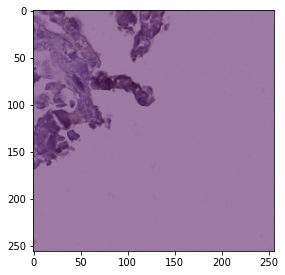

In [108]:
# imgsと予測マスクの画像を表示する
plot_batch(imgs, preds, size=5)

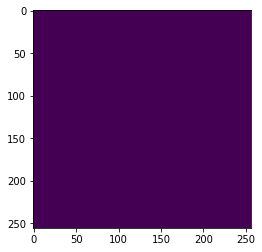

In [109]:
# 予測マスクだけを表示してみる。マスクと光るimgが重なったような図になっており完全におかしい
# 0枚目
m = 2
pred_m = preds[m].permute((1, 2, 0)).numpy()*255.0
plt.imshow(pred_m)
plt.show()
#print(pred_m[2100,1700])
#print(pred_m[1000,2000])
#print(np.max(pred_m[:,:]))

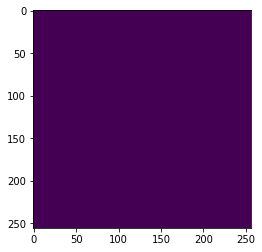

IndexError: index 1500 is out of bounds for axis 0 with size 256

In [110]:
# 比較用に学習用のマスクを表示してみる
m = 4
msk = msks[m].permute((1, 2, 0)).numpy()*255.0
plt.imshow(msk)
plt.show()
print("msk_1500_2700:",msk[1500,2700])
print("msk最大:",np.max(msk[:,:]))
msk_1 = msks[m].permute((1, 2, 0)).numpy()
print("msk_1_1500_2700:",msk_1[1500,2700])
print("msk_1_1500_2700_255:",msk_1[1500,2700]*255.0)
print("msk_1最大:",np.max(msk_1[:,:]))

In [ ]:
print(preds[0].size())
imgs[0].size()


In [ ]:
# 予測元のimageをチェック
m = 0
img_s = imgs[m].permute((1, 2, 0)).numpy()*255.0
img_s = img_s.astype('uint8')
plt.imshow(img_s)
plt.show()
print(img_s[1500,50])

In [ ]:
#!rm -r ./wandb